

# GFN-ROM is a resolution-invariant method for MOR suitable for multifidelity applications.

# For further details, see the [GFN repo](https://github.com/Oisin-M/GFN) and [GFN paper](https://arxiv.org/abs/2406.03569).

In [1]:
# Install PyTorch
try:
  import torch
  from torch import nn
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch
  from torch import nn

In [2]:
# Clone and import gfn-rom
import sys
try:
    from gfn_rom import pde, defaults, preprocessing, initialisation, gfn_rom, train, test, plotting
except ImportError:
    try:
        sys.path.append('GFN')
        from gfn_rom import pde, defaults, preprocessing, initialisation, gfn_rom, train, test, plotting
    except ImportError:
        !git clone https://github.com/Oisin-M/GFN.git
        from gfn_rom import pde, defaults, preprocessing, initialisation, gfn_rom, train, test, plotting

import numpy as np
import scipy

In [3]:
pname = 'advection'

# training and test fidelities
train_fidelities = ['3967']
test_fidelities = ['3967']

# Naming convention for saving the model
save_name = ''.join(train_fidelities)

In [4]:
dev = initialisation.set_device()
initialisation.set_precision(defaults.precision)
initialisation.create_directories()
params = torch.tensor(pde.params(pname)).to(dev)
np.random.seed(defaults.split_seed)
train_trajs, test_trajs = preprocessing.train_test_split(params, len(train_fidelities), defaults.rate)

xs=scipy.io.loadmat("../../dataset/advection_unstructured.mat")['xx'][:,0]
ys=scipy.io.loadmat("../../dataset/advection_unstructured.mat")['yy'][:,0]
meshes_train = [np.vstack([xs,ys]).T]
meshes_test = meshes_train
def get_scaled_data(fname="../../dataset/advection_unstructured.mat"):
    U = scipy.io.loadmat(fname)['U']
    U_orig = torch.tensor(U)
    scale, U_sc = preprocessing.scaling(U_orig)
    print('reconstruction error', ((U_orig - preprocessing.undo_scaling(U_sc, scale))**2).sum())
    return scale, U_sc
sols_train = [get_scaled_data()[1]]
sols_test = [get_scaled_data()]

sols_train = [x.to(dev) for x in sols_train]
initialisation.set_seed(defaults.seed)
start_mesh = sorted(meshes_train, key=lambda x: x.shape[0])[-1]
update_master = defaults.mode == 'adapt'

reconstruction error tensor(1.2425e-27)
reconstruction error tensor(1.2425e-27)


In [5]:
model = gfn_rom.GFN_ROM(start_mesh, defaults.N_basis_factor, params.shape[1], defaults.act, defaults.ae_sizes, defaults.mapper_sizes).to(dev)
print(model.GFN.mesh_m.shape)

# We do all of the possible expansions apriori in the preadaptive case
# This is a preprocessing step so we don't do any speedup steps here
if defaults.mode=='preadapt':
    count = np.inf
    while count!=0:
        count = 0
        for mesh_n in meshes_train:
            n_exp, n_agg = model.GFN.reshape_weights(mesh_n, update_master=True)
            count += n_exp
    print(model.GFN.mesh_m.shape)

(3967, 2)
(3967, 2)


In [6]:
if not update_master:
    opt = torch.optim.Adam(model.parameters(), lr=defaults.lr, weight_decay=defaults.lambda_)
else:
    # Cannot update GFN parameters using Adam anymore since we use adaptive method
    # and weights can change shape at each iteration
    # Similarly, cannot use momentum
    opt = torch.optim.SGD(model.parameters(), lr=defaults.lr, weight_decay=defaults.lambda_)

Training network


100%|██████████| 5000/5000 [01:02<00:00, 79.50it/s, Loss(training)=0.00116, Loss(testing)=0.558] 


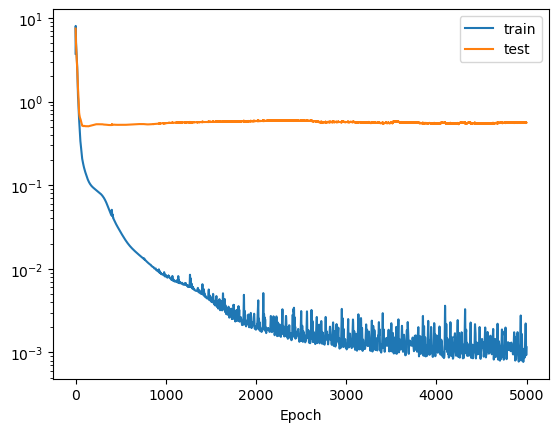

In [7]:
try:
    model.load_state_dict(torch.load("models/best_model_"+save_name+".pt"))
    print("Loading saved network")
except FileNotFoundError:
    print("Training network")
    train_losses, test_losses = train.train(model, opt, meshes_train, sols_train, params, train_trajs, test_trajs, update_master, defaults.epochs, defaults.mapper_weight, save_name)
    model.load_state_dict(torch.load("models/best_model_"+save_name+".pt"))
    plotting.plot_losses(train_losses, test_losses, save_name)

In [8]:
for i in range(len(test_fidelities)):
    
    print('-'*40)
    print(f'TEST MESH: {test_fidelities[i]}')
    
    scale, U = sols_test[i]
    U = U.to('cpu')
    mesh = meshes_test[i]

    model.eval()
    model.to('cpu')
    
    Z, Z_net, x_enc, x_map = test.evaluate_results(model, mesh, U, scale, params.to('cpu'))
    error = abs(Z - Z_net)
    error, rel_error = test.print_results(Z, Z_net, x_enc, x_map)

    np.savetxt('errors/relative_errors_train'+save_name+'_test'+test_fidelities[i]+'.txt', [max(rel_error), sum(rel_error)/len(rel_error), min(rel_error)])
    print()

----------------------------------------
TEST MESH: 3967

Maximum relative error for latent  =  1.7128177003166913
Mean relative error for latent =  0.21280120159796795
Minimum relative error for latent =  0.01835151570682932

Maximum absolute error for field  =  45.04075824162928
Mean absolute error for field  =  7.418409593706943
Minimum absolute error for field  =  0.18413877976837698

Maximum relative error for field  =  0.5350034503318564
Mean relative error for field  =  0.13626338642109592
Minimum relative error for field  =  0.0399207351824135

